In [1]:
import os  
import torch  
import torch.nn as nn  
import torch.optim as optim  
from torchvision import  transforms, models  
from torch.utils.data import DataLoader  
from sklearn.metrics import classification_report, confusion_matrix  
import matplotlib.pyplot as plt  
import seaborn as sns 
import numpy as np  

In [3]:
alldatasets=os.listdir(r"C:\Users\yigit\Downloads\archive(20)\SkyFusion")

train_data=r"C:\Users\yigit\Downloads\archive(20)\SkyFusion\train"
val_data=r"C:\Users\yigit\Downloads\archive(20)\SkyFusion\valid"
test_data=r"C:\Users\yigit\Downloads\archive(20)\SkyFusion\test"

In [5]:
def check_directory_contents(directory):
    if os.path.exists(directory):
        categories = os.listdir(directory)
        print(f"Categories in {directory}: {categories}")
        for category in categories:
            category_path = os.path.join(directory, category)
            if os.path.isdir(category_path):
                files = os.listdir(category_path)
                print(f" - {category} contains {len(files)} files")
    else:
        print(f"Directory not found: {directory}")

print("\nChecking Training Dataset:")
check_directory_contents(train_data)

print("\nChecking Validation Dataset:")
check_directory_contents(val_data)

print("\nChecking Testing Dataset:")
check_directory_contents(test_data)


Checking Training Dataset:
Categories in C:\Users\yigit\Downloads\archive(20)\SkyFusion\train: ['003b48a9e_png_jpg.rf.fea97d0443800bc662d17ff7c8db3bcc.jpg', '014de911-7810-4f7d-8967-3e5402209f4a_0_0_jpg.rf.77e233628eec19d0fa0cc4a57a977fce.jpg', '014de911-7810-4f7d-8967-3e5402209f4a_0_0_jpg.rf.c71a4a6660370056f6308e2412c18e37.jpg', '014de911-7810-4f7d-8967-3e5402209f4a_0_1060_jpg.rf.464a7849e3b6a9163619d08e5463a8f2.jpg', '014de911-7810-4f7d-8967-3e5402209f4a_0_1060_jpg.rf.f751e477f27e7187519af91b312cbcdb.jpg', '014de911-7810-4f7d-8967-3e5402209f4a_1060_0_jpg.rf.a2fe6e35705d2589a57d3e2b2ba28e9c.jpg', '014de911-7810-4f7d-8967-3e5402209f4a_1060_0_jpg.rf.ef9ea5eef894be8fb1c4e65844670c7d.jpg', '014de911-7810-4f7d-8967-3e5402209f4a_1060_1060_jpg.rf.1cd6d6165c0cbe0662444868a97943c0.jpg', '014de911-7810-4f7d-8967-3e5402209f4a_1060_1060_jpg.rf.5f615f0af2d8cdaab68d415245f2188b.jpg', '01b2b29c7_png_jpg.rf.568638eaf5c108b2200b7cfdf994c544.jpg', '01b6d88ec_png_jpg.rf.b075bc40beb567d0ca10dae76b55009

Visualizing Training Dataset:
Total images in Training Dataset: 2095

Visualizing samples from Training Dataset:


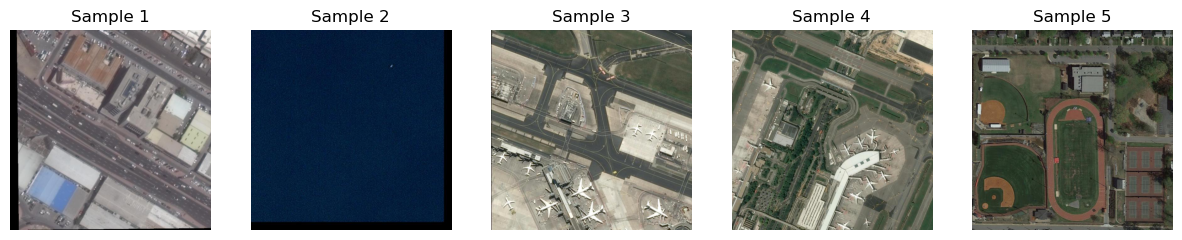


Visualizing Validation Dataset:
Total images in Validation Dataset: 450

Visualizing samples from Validation Dataset:


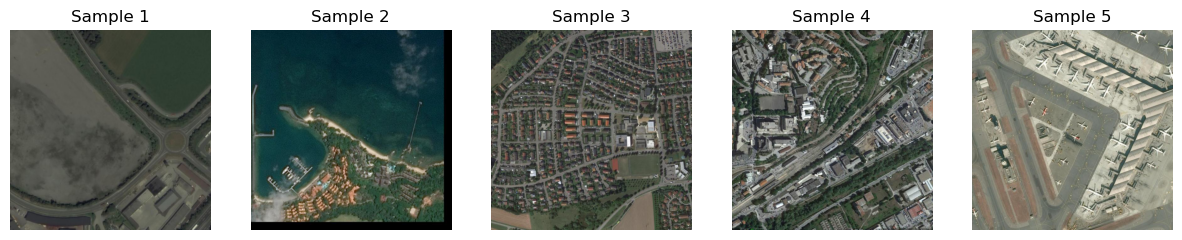


Visualizing Testing Dataset:
Total images in Testing Dataset: 450

Visualizing samples from Testing Dataset:


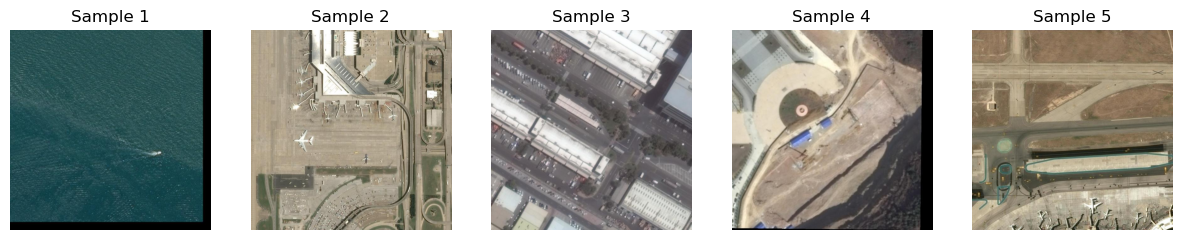

In [7]:

import random
#import cv2
from PIL import Image

def visualize_samples(directory, num_samples=5):
    if os.path.exists(directory):
       
        image_files = [os.path.join(directory, f) for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
        
       
        selected_images = random.sample(image_files, min(num_samples, len(image_files)))
        
        plt.figure(figsize=(15, 5))
        for idx, img_path in enumerate(selected_images):
            
            img = Image.open(img_path)
            plt.subplot(1, num_samples, idx + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"Sample {idx + 1}")
        plt.show()
    else:
        print(f"Directory not found: {directory}")


def count_and_visualize_data(dataset_path, dataset_name):
    total_images = sum([len(files) for r, d, files in os.walk(dataset_path)])
    print(f"Total images in {dataset_name}: {total_images}")

    print(f"\nVisualizing samples from {dataset_name}:")
    visualize_samples(dataset_path)


print("Visualizing Training Dataset:")
count_and_visualize_data(train_data, "Training Dataset")

print("\nVisualizing Validation Dataset:")
count_and_visualize_data(val_data, "Validation Dataset")

print("\nVisualizing Testing Dataset:")
count_and_visualize_data(test_data, "Testing Dataset")

In [9]:
from torchvision import transforms


train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),   
    transforms.RandomVerticalFlip(p=0.5),      
    transforms.RandomRotation(degrees=20),     
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  
    transforms.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0)), 
    transforms.ToTensor(),                     
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])


val_test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])





Data augmentation setup completed!


In [11]:
import os
import json

from torch.utils.data import Dataset

class CustomDatasetWithAnnotations(Dataset):
    def __init__(self, root, transforms=None, set_type="train"):
        self.root = root
        self.transforms = transforms
        self.set_type = set_type

        
        if set_type == "train":
            annotation_path = r"C:\Users\yigit\Downloads\archive(20)\SkyFusion\train\_annotations.coco.json"
        elif set_type == "valid":
            annotation_path = r"C:\Users\yigit\Downloads\archive(20)\SkyFusion\valid\_annotations.coco.json"
        else:  
            annotation_path = r"C:\Users\yigit\Downloads\archive(20)\SkyFusion\test\_annotations.coco.json"

        print(f"Using annotation path: {annotation_path}")

        if not os.path.exists(annotation_path):
            raise FileNotFoundError(f"Annotation file not found: {annotation_path}")

        with open(annotation_path) as f:
            self.annotations = json.load(f)

        
        valid_extensions = ('.jpg', '.jpeg', '.png')
        self.imgs = [img for img in sorted(os.listdir(os.path.join(self.root))) if img.lower().endswith(valid_extensions)]

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.imgs[idx])
        try:
            img = Image.open(img_path).convert("RGB")
        except UnidentifiedImageError:
            print(f"Cannot identify image file: {img_path}")
            raise

        annotation = self.annotations['annotations'][idx]

        
        x_min, y_min, width, height = annotation['bbox']
        if width <= 0 or height <= 0:
            raise ValueError(f"Invalid bounding box found for image at index {idx}: {annotation['bbox']}")

        
        boxes = torch.tensor([[x_min, y_min, x_min + width, y_min + height]], dtype=torch.float32)

        labels = torch.tensor([annotation['category_id']], dtype=torch.int64)

       
        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([idx]),
            'area': torch.tensor([width * height], dtype=torch.float32),
            'iscrowd': torch.tensor([annotation.get('iscrowd', 0)], dtype=torch.int64)
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [13]:
from torch.utils.data import DataLoader

train_dataset = CustomDatasetWithAnnotations(
    root=r"C:\Users\yigit\Downloads\archive(20)\SkyFusion\train",
    transforms=train_transform,
    set_type="train"
)

val_dataset = CustomDatasetWithAnnotations(
    root=r"C:\Users\yigit\Downloads\archive(20)\SkyFusion\valid",
    transforms=val_test_transform,
    set_type="valid"
)

test_dataset = CustomDatasetWithAnnotations(
    root=r"C:\Users\yigit\Downloads\archive(20)\SkyFusion\test",
    transforms=val_test_transform,
    set_type="test"
)


Using annotation path: C:\Users\yigit\Downloads\archive(20)\SkyFusion\train\_annotations.coco.json
Using annotation path: C:\Users\yigit\Downloads\archive(20)\SkyFusion\valid\_annotations.coco.json
Using annotation path: C:\Users\yigit\Downloads\archive(20)\SkyFusion\test\_annotations.coco.json


In [15]:

for i in range(3):
    img, target = train_dataset[i]
    print(f"Image {i}: {img.size}, Annotations: {target}")


Image 0: <built-in method size of Tensor object at 0x000002C974CCF430>, Annotations: {'boxes': tensor([[259.0000,  49.0000, 263.8000,  58.6000]]), 'labels': tensor([3]), 'image_id': tensor([0]), 'area': tensor([46.0800]), 'iscrowd': tensor([0])}
Image 1: <built-in method size of Tensor object at 0x000002C975A284B0>, Annotations: {'boxes': tensor([[284.0000, 630.0000, 288.8000, 638.8000]]), 'labels': tensor([3]), 'image_id': tensor([1]), 'area': tensor([42.2400]), 'iscrowd': tensor([0])}
Image 2: <built-in method size of Tensor object at 0x000002C975A285A0>, Annotations: {'boxes': tensor([[281.0000, 568.0000, 285.0000, 576.8000]]), 'labels': tensor([3]), 'image_id': tensor([2]), 'area': tensor([35.2000]), 'iscrowd': tensor([0])}


In [17]:
from torch.utils.data import DataLoader


def custom_collate_fn(batch):
    images, targets = zip(*batch)  
    images = list(images)  
    targets = list(targets)  
    return images, targets


train_loader = DataLoader(
    train_dataset, batch_size=4, shuffle=True, num_workers=0, collate_fn=custom_collate_fn
)
val_loader = DataLoader(
    val_dataset, batch_size=4, shuffle=False, num_workers=0, collate_fn=custom_collate_fn
)
test_loader = DataLoader(
    test_dataset, batch_size=4, shuffle=False, num_workers=0, collate_fn=custom_collate_fn
)




Data loaders created successfully!


In [19]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn(weights=weights)


num_classes = 4  
in_features = model.roi_heads.box_predictor.cls_score.in_features


model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

print("Faster R-CNN model setup completed!")



Faster R-CNN model setup completed!


In [21]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)


params = [p for p in model.parameters() if p.requires_grad]


optimizer = torch.optim.SGD(params, lr=0.0003, momentum=0.9, weight_decay=0.0005)


lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

print("Model, optimizer, and scheduler set up completed!")


Model, optimizer, and scheduler set up completed!


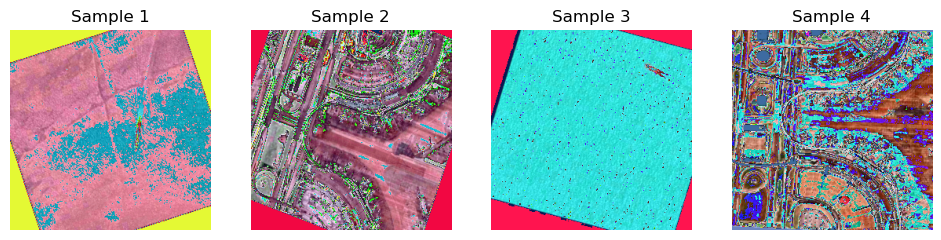

In [23]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

def visualize_augmented_samples(data_loader, num_samples=5):
    
    data_iter = iter(data_loader)
    images, targets = next(data_iter)
    
    
    plt.figure(figsize=(15, 5))
    for i in range(min(num_samples, len(images))):
        img = to_pil_image(images[i])
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Sample {i + 1}")
    plt.show()


visualize_augmented_samples(train_loader)

In [31]:
for images, targets in train_loader:
    print(targets)
    break


[{'boxes': tensor([[110., 187., 140., 231.]]), 'labels': tensor([1]), 'image_id': tensor([869]), 'area': tensor([1320.]), 'iscrowd': tensor([0])}, {'boxes': tensor([[334.0000,  60.0000, 337.2000,  68.8000]]), 'labels': tensor([3]), 'image_id': tensor([954]), 'area': tensor([28.1600]), 'iscrowd': tensor([0])}, {'boxes': tensor([[571.0000, 446.0000, 578.2000, 455.6000]]), 'labels': tensor([3]), 'image_id': tensor([968]), 'area': tensor([69.1200]), 'iscrowd': tensor([0])}, {'boxes': tensor([[437.0000, 109.0000, 449.8000, 138.6000]]), 'labels': tensor([3]), 'image_id': tensor([907]), 'area': tensor([378.8800]), 'iscrowd': tensor([0])}]


In [33]:

num_epochs = 10


train_losses = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1} of {num_epochs}")
    model.train()
    epoch_loss = 0

    for images, targets in train_loader:
      
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

       
        if any(t is None or not t['boxes'].size(0) for t in targets):
            print("Skipping batch due to missing or empty targets.")
            continue

        try:
           
            loss_dict = model(images, targets)
        except AssertionError as e:
            print(f"Assertion Error: {e}")
            print("Error occurred at the following target(s):", targets)
            continue  

       
        losses = sum(loss for loss in loss_dict.values())

      
        optimizer.zero_grad()
        losses.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)  
        optimizer.step()

        
        epoch_loss += losses.item()

   
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)

    print(f"Epoch Loss: {avg_epoch_loss:.4f}")
    lr_scheduler.step()

print("Training Complete!")


Epoch 1 of 10
Epoch Loss: 25.2271
Epoch 2 of 10
Epoch Loss: 18.9220
Epoch 3 of 10
Epoch Loss: 17.4066
Epoch 4 of 10
Epoch Loss: 17.1084
Epoch 5 of 10
Epoch Loss: 16.5910
Epoch 6 of 10
Epoch Loss: 16.3012
Epoch 7 of 10
Epoch Loss: 16.3753
Epoch 8 of 10
Epoch Loss: 16.2014
Epoch 9 of 10
Epoch Loss: 16.3615
Epoch 10 of 10
Epoch Loss: 16.2190
Training Complete!


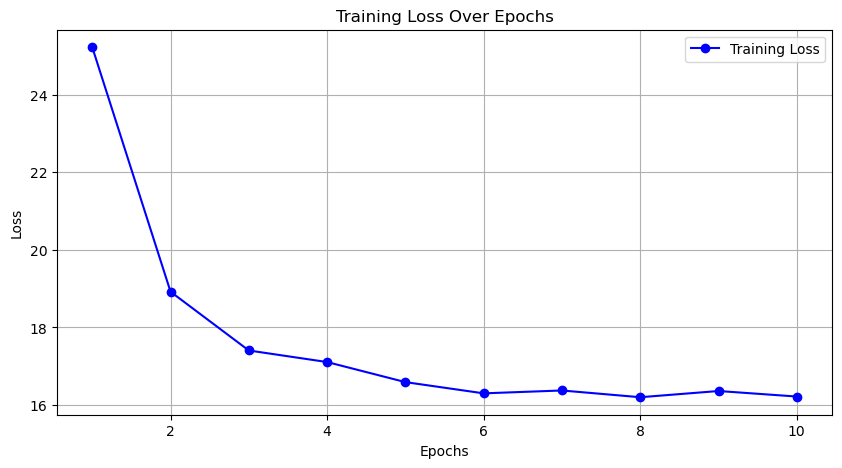

In [35]:
import matplotlib.pyplot as plt


epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, marker='o', linestyle='-', color='b', label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [37]:
torch.save(model.state_dict(), "faster_rcnn_model.pth")
print("Model saved successfully!")


Model saved successfully!


In [39]:
model.eval()  
all_true_labels = []
all_pred_labels = []

with torch.no_grad():
    for images, targets in test_loader:  
        images = list(image.to(device) for image in images)
        outputs = model(images)

        for i, output in enumerate(outputs):
            true_labels = targets[i]['labels'].cpu().numpy()
            pred_labels = output['labels'].cpu().numpy() if len(output['labels']) > 0 else []

            all_true_labels.extend(true_labels)
            all_pred_labels.extend(pred_labels)


min_len = min(len(all_true_labels), len(all_pred_labels))
all_true_labels = all_true_labels[:min_len]
all_pred_labels = all_pred_labels[:min_len]


from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(all_true_labels, all_pred_labels, average='weighted', zero_division=1)
recall = recall_score(all_true_labels, all_pred_labels, average='weighted', zero_division=1)
f1 = f1_score(all_true_labels, all_pred_labels, average='weighted', zero_division=1)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Precision: 0.39
Recall: 0.34
F1 Score: 0.36


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 1500x1500 with 0 Axes>

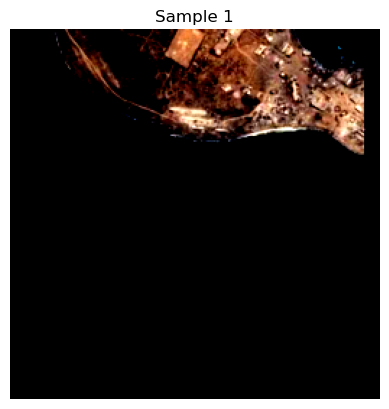

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


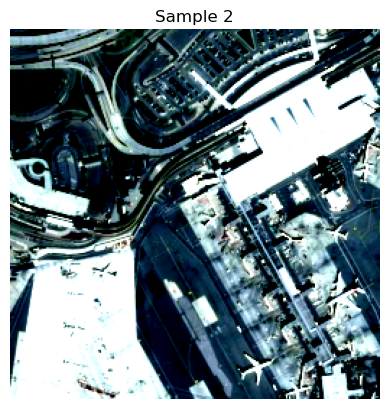

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


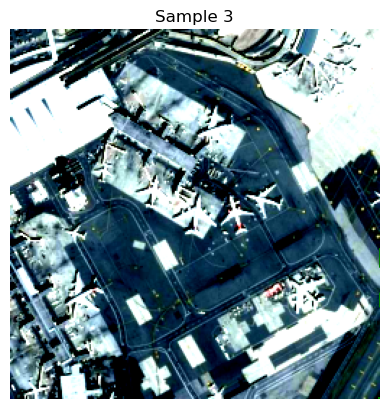

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


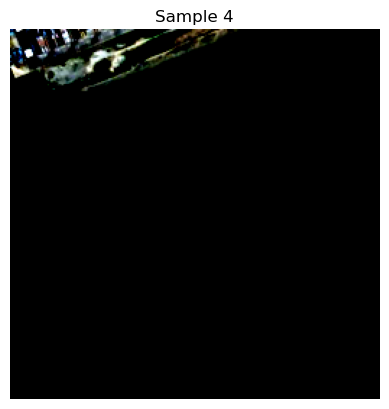

In [41]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def visualize_predictions(images, outputs, num_samples=4):
    plt.figure(figsize=(15, 15))
    for idx, (image, output) in enumerate(zip(images, outputs)):
        if idx >= num_samples:
            break
        
        
        img = image.cpu().permute(1, 2, 0).numpy()
        
        fig, ax = plt.subplots(1)
        ax.imshow(img)

       
        for box in output['boxes']:
            x_min, y_min, x_max, y_max = box.cpu().numpy()
            rect = Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='g', facecolor='none')
            ax.add_patch(rect)

        plt.axis('off')
        plt.title(f"Sample {idx + 1}")
        plt.show()


with torch.no_grad():
    test_images, _ = next(iter(test_loader))  
    test_images = list(img.to(device) for img in test_images)
    test_outputs = model(test_images)
    visualize_predictions(test_images, test_outputs)
